#Импорты

In [ ]:
!pip install catboost
!pip install optuna
import optuna
from catboost import CatBoostRegressor

In [ ]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
tqdm.pandas()
from itertools import product
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import re
from sklearn.model_selection import train_test_split
import torch
from sklearn.decomposition import PCA
import gc
import math
import matplotlib as mpl
from transformers import AutoTokenizer, AutoModel

In [ ]:
def MAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (np.abs(x - y)/np.abs(x)).mean()

def MAE(x,y):
    # Mean absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return np.abs(x - y).mean()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE_PATH = "drive/MyDrive/Studcamp/"

#1. Обработка данных MOEX

Деление в колонках:

*   Capitalization - 1e12
*   DIVISOR - 1e9
*   VALUE - 1e9

In [ ]:
def process_moex(moex):
    #1. В начале файла 2 пустые строки
    moex.drop([0, 1], axis=0, inplace=True)
    moex.rename(columns=moex.iloc[0], inplace=True)
    moex.drop([2], inplace=True, axis=0)
    moex.reset_index(inplace=True, drop=True)


    #2. Преобразование колонок в нужный формат
    moex.TRADEDATE = pd.to_datetime(moex.TRADEDATE, format='%d.%m.%Y')
    moex.CAPITALIZATION = moex.CAPITALIZATION.str.replace(',', '.').astype(float) / 1e12
    moex.DIVISOR = moex.DIVISOR.str.replace(',', '.').astype(float) / 1e9
    for cat in ['OPEN', 'CLOSE', 'HIGH', 'LOW']:
        moex[cat] = moex[cat].str.replace(',', '.').astype(float)

    #4. Дропаем лишнее и убираем NaNы
    drop_columns = ['NAME', 'SHORTNAME', 'SECID', 'BOARDID', 'DURATION', 'YIELD', 'DECIMALS', 'CURRENCYID', 'VOLUME', 'TRADINGSESSION', 'VALUE']
    moex.drop(drop_columns, axis=1, inplace=True)
    moex = moex[moex.CAPITALIZATION.notna()]
    moex = moex[moex.DIVISOR.notna()]

    #5. Новые признаки
    moex['RANGE_PAST'] = (moex.HIGH - moex.LOW).shift()
    moex['CLOSE_PAST'] = moex.CLOSE.shift()
    moex['DAY'] = moex.TRADEDATE.dt.day
    moex['DAY_OF_WEEK'] = moex.TRADEDATE.dt.dayofweek
    moex['MONTH'] = moex.TRADEDATE.dt.month
    moex['CAPITALIZATION_PAST'] = moex.CAPITALIZATION.shift()
    moex['DIVISOR_PAST'] = moex.DIVISOR.shift()

    moex = moex[1:]
    return moex

In [ ]:
full_moex = pd.read_excel(BASE_PATH + 'moex_2004_2024.xlsx')
full_moex.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18
0,history,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE,DURATION,YIELD,DECIMALS,CAPITALIZATION,CURRENCYID,DIVISOR,TRADINGSESSION,VOLUME
3,SNDX,IMOEX,05.01.2004,Индекс МосБиржи,Индекс МосБиржи,"542,19","514,71","542,51","514,71","6467250541,88",NaN,NaN,2,NaN,RUB,NaN,3,NaN
4,SNDX,IMOEX,06.01.2004,Индекс МосБиржи,Индекс МосБиржи,"543,94","542,19","548,94","540,7","6000835972,45",NaN,NaN,2,NaN,RUB,NaN,3,NaN


In [ ]:
full_moex = process_moex(full_moex.copy())
full_moex.head()

,TRADEDATE,CLOSE,OPEN,HIGH,LOW,CAPITALIZATION,DIVISOR,RANGE_PAST,CLOSE_PAST,DAY,DAY_OF_WEEK,MONTH,CAPITALIZATION_PAST,DIVISOR_PAST
2284,2013-03-05,1484.22,1463.98,1486.19,1462.49,4.830844,3.254812,15.82,1464.45,5,1,3,4.766505,3.254812
2285,2013-03-06,1491.49,1485.04,1498.07,1485.04,4.854518,3.254812,23.70,1484.22,6,2,3,4.830844,3.254812
2286,2013-03-07,1491.35,1491.99,1498.29,1489.02,4.854075,3.254812,13.03,1491.49,7,3,3,4.854518,3.254812
2287,2013-03-11,1504.05,1491.14,1516.49,1491.14,4.895383,3.254812,9.27,1491.35,11,0,3,4.854075,3.254812
2288,2013-03-12,1501.76,1503.98,1506.42,1494.92,4.887960,3.254812,25.35,1504.05,12,1,3,4.895383,3.254812


In [ ]:
unknown_cats = ['OPEN', 'HIGH', 'LOW', 'CAPITALIZATION', 'DIVISOR']
moex = full_moex.drop(unknown_cats, axis=1)

In [ ]:
first_news_date = '2015-01-05'

In [ ]:
moex = moex[moex.TRADEDATE >= first_news_date]

In [ ]:
moex.to_csv(BASE_PATH + 'cleaned_moex.csv')

In [ ]:
moex.drop(['TRADEDATE'], axis=1, inplace=True)

#2. Исследование данных MOEX

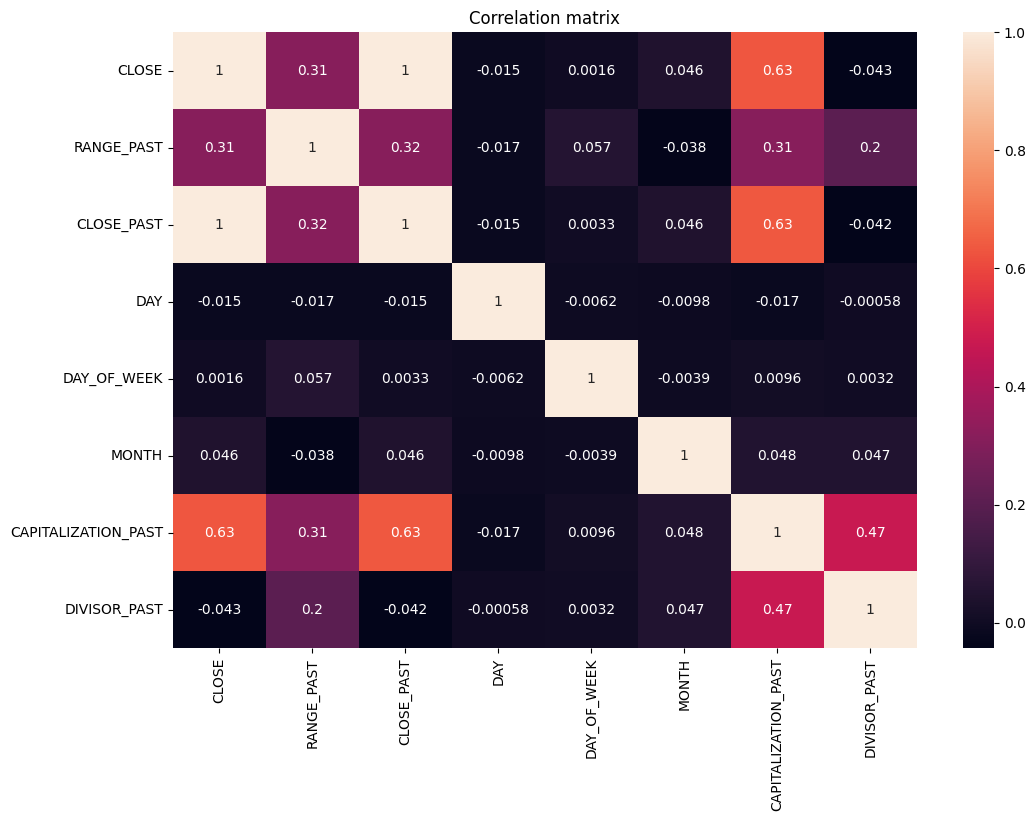

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Correlation matrix')
sns.heatmap(moex.corr(method='spearman'), annot=True)
plt.show()

In [ ]:
moex_X = moex.drop(['CLOSE'], axis=1)
moex_y = moex['CLOSE']

In [ ]:
model = CatBoostRegressor(iterations=500, depth=16, verbose=False)
model.fit(moex_X, moex_y)

In [ ]:
colors = ['red', 'orange', 'yellow', 'springgreen', 'aqua', 'deepskyblue', 'purple', 'chocolate'][::-1]

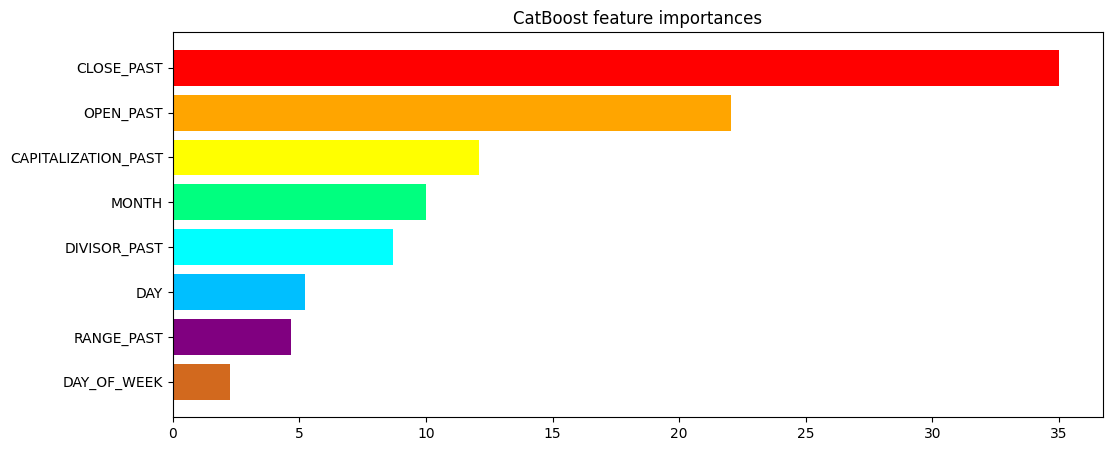

In [ ]:
importances = model.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(12, 5))
plt.title("CatBoost feature importances")
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center', color=colors)
plt.yticks(range(len(sorted_idx)), np.array(moex_X.columns)[sorted_idx])
plt.show()

# 3. Обработка статей

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
if torch.cuda.is_available():
    model.cuda()

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

def process_headlines(name):
    data =  pd.read_csv(BASE_PATH + name)
    data.drop_duplicates('title', inplace=True)
    data.reset_index(inplace=True, drop=True)
    bert_embs = data.text.progress_apply(lambda x: embed_bert_cls(x, model, tokenizer))
    data = pd.concat([data, pd.DataFrame(bert_embs.to_list(), columns=[i for i in range(312)])], axis=1)
    data.date = pd.to_datetime(data.date)
    return data

##3.1 Экономика

In [ ]:
economics_headlines = process_headlines('kommersant_economics_2015_2024.csv')

##3.2 Финансы

In [ ]:
financial_headlines = process_headlines('kommersant_financial_2015_2024.csv')

##3.3 Политика

In [ ]:
politics_headlines = process_headlines('kommersant_politics_2015_2024.csv')

Cleaning text...


100%|██████████| 48872/48872 [01:24<00:00, 580.81it/s]


Getting embeddings...


100%|██████████| 48872/48872 [03:09<00:00, 258.28it/s]


In [ ]:
politics_headlines.to_csv(BASE_PATH + 'politics_headlines_embedded.csv')

#4. Dataset

In [ ]:
economics_news = pd.read_csv(BASE_PATH + 'economics_texts_embedded_2015_2024.csv', index_col=0)
financial_news = pd.read_csv(BASE_PATH + 'financial_texts_embedded_2015_2024.csv', index_col=0)
politics_news = pd.read_csv(BASE_PATH + 'politics_texts_embedded_2015_2024.csv', index_col=0)
moex = pd.read_csv(BASE_PATH + 'cleaned_moex.csv', index_col=0)

In [ ]:
news = pd.concat([economics_news, financial_news, politics_news], axis=0)
news

,date,text,0,1,2,3,4,5,6,7,...,302,303,304,305,306,307,308,309,310,311
0,2024-04-11,\n\nДефицит бюджета в 2024 году будет плановым...,0.040171,0.019572,0.019662,-0.027160,-0.025944,-0.085018,0.004387,0.007695,...,0.030537,-0.069169,-0.023348,-0.005164,0.018416,-0.008021,0.005063,0.022208,0.031006,-0.046911
1,2024-04-11,"\n\nРосреестр подготовил законопроект, предусм...",0.080410,-0.074555,0.035703,0.036453,-0.048477,0.012201,0.050878,-0.017043,...,0.073817,-0.035681,0.029512,0.049115,0.033251,0.032004,0.013853,-0.016760,0.018065,0.013004
2,2024-04-11,"\n\nБолее половины (58,6%) российских компаний...",0.088623,-0.026157,-0.025560,-0.023174,-0.021608,-0.041555,-0.034583,-0.048470,...,0.008398,-0.003418,-0.017642,0.014744,0.003932,0.003578,0.055675,0.012300,0.016301,-0.049698
3,2024-04-11,\n\nРоссийская академия наук усиливает свое вл...,0.012239,-0.038404,0.033471,0.019615,-0.074075,-0.043760,0.028888,-0.078620,...,0.025253,-0.054164,0.006108,-0.012739,-0.022655,0.025654,0.001510,0.029801,-0.028011,-0.082330
4,2024-04-10,\n\nСнижению ключевой ставки препятствует сохр...,0.075083,0.014421,0.067371,-0.024116,-0.037318,-0.059200,-0.031042,0.005099,...,0.066611,-0.062747,-0.055941,0.059223,0.024200,-0.008053,0.050206,0.022194,0.032268,-0.039383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35992,2015-01-09,\n\nПресс-секретарь президента России Дмитрий ...,-0.053872,-0.034641,0.006413,-0.067200,-0.077334,-0.045037,-0.001086,-0.045142,...,0.002185,0.054253,-0.012230,0.026929,-0.065749,0.035395,0.069837,0.076124,-0.010581,-0.079766
35993,2015-01-09,\n\nСеверная Корея попыталась приобрести в Рос...,-0.010532,0.036877,-0.008736,-0.058873,-0.061117,-0.020501,0.071006,-0.037168,...,-0.038542,0.009515,0.038641,0.062377,-0.003218,0.025497,-0.015629,0.030774,0.020285,-0.113501
35994,2015-01-08,\n\nВ Москве на 84-м году жизни после продолжи...,-0.024668,-0.015951,-0.040398,-0.046180,-0.001444,-0.079275,-0.023015,-0.044268,...,0.002480,0.099160,0.051192,0.001398,-0.024568,0.023895,-0.027827,-0.039924,0.041614,-0.046479
35995,2015-01-08,\n\nПремьер-министр Дмитрий Медведев назначил ...,0.011415,-0.022514,0.032020,-0.027934,0.010908,0.030734,-0.017849,-0.095956,...,0.013769,0.027967,-0.005092,0.039496,-0.007804,0.006767,-0.000526,0.064541,0.076456,-0.134547


In [ ]:
class MoexNewsDataset:

    def __init__(self, alpha, n_components=None, test_size=None):
        self.__alpha = alpha
        self.__n_components = n_components
        self.__pca = None
        self.__test_size = test_size
        n = n_components if n_components else 312
        self.__columns = ['{}'.format(i) for i in range(n)]

    def __get_pca_embeddings(self, news):

        data = np.array(news)
        if self.__n_components is not None:
            self.__pca = PCA(n_components=self.__n_components)
            if self.__test_size:
                n = len(news)
                data1 = news.iloc[: int(n * (1 - self.__test_size))]
                data2 = news.iloc[int(n * (1 - self.__test_size)): ]
                data1 = self.__pca.fit_transform(data1)
                data2 = self.__pca.transform(data2)
                data = np.concatenate([data1, data2], axis=0)
            else:
              data = self.__pca.fit_transform(data)
        return pd.DataFrame(data, columns=self.__columns)

    def __get_date_embeddings(self, news, unique_dates):

        date_embeddings = pd.DataFrame()
        news_embeddings = news.drop(['date'], axis=1)
        for date in unique_dates:
            embs = news_embeddings[news.date == date]
            date_embedding = embs
            # Weekends - on Monday
            if date.dayofweek == 0:
                for j in [1, 2]:
                    weekend_news =  news_embeddings[news.date == date - timedelta(days=j)]
                    date_embedding = pd.concat([date_embedding, weekend_news], axis=0)
            date_embedding = date_embedding.mean(axis=0).to_numpy().reshape(1, -1)
            date_embeddings = pd.concat([date_embeddings, pd.DataFrame(date_embedding, columns=self.__columns)], axis=0)

        return date_embeddings.reset_index(drop=True)

    def __moving_average(self, date_embeddings):
        date_embeddings = date_embeddings.to_numpy()
        history = date_embeddings[0]
        new_embeddings = [history]
        for i in range(1, len(date_embeddings)):
            embedding = date_embeddings[i]
            if np.isnan(embedding).any():
                new_embeddings.append(history)
            else:
                history = self.__alpha * history + (1 - self.__alpha) * embedding
                new_embeddings.append(history)
        return np.array(new_embeddings)

    def make_data(self, news_true, moex_true):

        news = news_true.copy()
        moex = moex_true.copy()
        moex.TRADEDATE = pd.to_datetime(moex.TRADEDATE)
        news.date = pd.to_datetime(news.date)

        pca_embeddings = self.__get_pca_embeddings(news.drop(['date', 'text'], axis=1))

        news_embeddings = pd.concat([pd.DataFrame(news.date).reset_index(drop=True), pca_embeddings], axis=1)
        unique_dates =  pd.Series(news.date.unique(), name='TRADEDATE')
        date_embeddings = self.__get_date_embeddings(news_embeddings, unique_dates)
        date_embeddings = pd.concat([pd.DataFrame(unique_dates), date_embeddings], axis=1)
        date_embeddings.set_index('TRADEDATE', inplace=True)
        moex.set_index('TRADEDATE', inplace=True)
        dataset = moex.join(date_embeddings)

        dataset[self.__columns] = self.__moving_average(dataset[self.__columns])
        dataset.reset_index(drop=True, inplace=True)
        news = None
        moex = None
        gc.collect()
        return dataset

    def pca(self):
        return self.__pca

In [ ]:
dataset = MoexNewsDataset(alpha=0.1, test_size=0.2)
dataset.make_data(news, moex)

,CLOSE,RANGE_PAST,CLOSE_PAST,DAY,DAY_OF_WEEK,MONTH,CAPITALIZATION_PAST,DIVISOR_PAST,0,1,...,302,303,304,305,306,307,308,309,310,311
0,1435.66,51.47,1396.61,5,0,1,6.473978,4.635503,-0.006502,0.037429,...,-0.023283,-0.019100,-0.036925,0.045501,-0.013601,0.032677,-0.018205,0.024445,0.046758,-0.091995
1,1480.73,48.38,1435.66,6,1,1,6.655000,4.635503,0.043750,0.053229,...,0.033704,0.056253,-0.040267,0.018554,-0.071957,0.053501,0.035820,0.053961,0.020195,-0.093400
2,1547.39,50.88,1480.73,8,3,1,6.863935,4.635503,0.024679,0.011070,...,0.029344,0.005043,0.000255,0.031929,-0.018812,0.018555,0.011772,0.020705,0.041367,-0.064578
3,1515.37,82.94,1547.39,9,4,1,7.172914,4.635503,0.018921,0.009638,...,0.024569,-0.005818,-0.037463,0.041737,0.000637,0.008734,0.025103,0.061560,0.027853,-0.080848
4,1513.22,61.79,1515.37,12,0,1,7.024481,4.635503,0.019211,-0.013314,...,0.014054,-0.015752,-0.018603,0.044949,-0.009530,0.010357,0.008551,0.025222,0.032167,-0.063297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317,3395.59,18.14,3371.29,3,2,4,5.948018,1.764313,0.041123,-0.018048,...,0.029497,-0.031031,-0.009995,0.039742,0.002201,-0.003824,-0.010510,0.032144,0.034393,-0.054547
2318,3407.57,20.70,3395.59,4,3,4,5.990890,1.764313,0.051162,-0.011242,...,0.029825,-0.031748,-0.017064,0.046143,-0.013285,-0.010888,-0.012951,0.036656,0.034821,-0.059929
2319,3395.37,17.56,3407.57,5,4,4,6.012013,1.764313,0.031183,-0.019823,...,0.025873,-0.010667,-0.013081,0.052749,-0.006207,-0.011751,-0.014415,0.042248,0.038343,-0.058255
2320,3417.38,15.74,3395.37,8,0,4,5.990502,1.764313,0.045362,-0.018598,...,0.027838,-0.019214,-0.012449,0.045588,-0.004652,-0.006561,-0.011243,0.028841,0.030626,-0.058238


In [ ]:
moex

,TRADEDATE,CLOSE,RANGE_PAST,CLOSE_PAST,DAY,DAY_OF_WEEK,MONTH,CAPITALIZATION_PAST,DIVISOR_PAST
2744,2015-01-05,1435.66,51.47,1396.61,5,0,1,6.473978,4.635503
2745,2015-01-06,1480.73,48.38,1435.66,6,1,1,6.655000,4.635503
2746,2015-01-08,1547.39,50.88,1480.73,8,3,1,6.863935,4.635503
2747,2015-01-09,1515.37,82.94,1547.39,9,4,1,7.172914,4.635503
2748,2015-01-12,1513.22,61.79,1515.37,12,0,1,7.024481,4.635503
...,...,...,...,...,...,...,...,...,...
5061,2024-04-03,3395.59,18.14,3371.29,3,2,4,5.948018,1.764313
5062,2024-04-04,3407.57,20.70,3395.59,4,3,4,5.990890,1.764313
5063,2024-04-05,3395.37,17.56,3407.57,5,4,4,6.012013,1.764313
5064,2024-04-08,3417.38,15.74,3395.37,8,0,4,5.990502,1.764313


#5. CatBoostRegressor

In [ ]:
test_size=0.1
val_size = 0.1
alphas = np.logspace(-3, -1, 3)
lrs = np.logspace(-3, -1, 3)
depths = [2, 4]

test_dataset_params = None
best_mae = 150
best_mape = None
best_params = None

iter = 1
n_blocks = 40
length = len(moex)
train_blocks = 25
block_size = length // n_blocks
val_size = 1 / train_blocks

for alpha, lr, depth in tqdm(list(product(alphas, lrs, depths))):

      print('\nIteration {} (alpha = {}, learning_rate = {}, depth = {}):'.format(iter, alpha, lr, depth))
      print('Cross-validating...')

      n = 0
      mean_mae = 0
      mean_mape = 0
      for j in tqdm(range(n_blocks - train_blocks + 1)):

          moex_tmp = moex[j * block_size: block_size * (train_blocks + j)]
          start_date = moex_tmp.TRADEDATE.min()
          end_date = moex_tmp.TRADEDATE.max()
          news_tmp = news[(news.date >= start_date) & (news.date <= end_date)]
          dataset = MoexNewsDataset(alpha=alpha, n_components=20, test_size=val_size)
          data = dataset.make_data(news_tmp, moex_tmp)
          N = len(data)
          data_train = data.iloc[: int(N * (1 - val_size))]
          data_val = data.iloc[int(N * (1 - val_size)): ]
          X_train, X_val, y_train, y_val = data_train.drop(['CLOSE'], axis=1), data_val.drop(['CLOSE'], axis=1), data_train['CLOSE'], data_val['CLOSE']
          model = CatBoostRegressor(depth=depth, learning_rate=lr, random_state=42, verbose=False)
          model.fit(X_train, y_train)
          preds = model.predict(X_val)
          mean_mae += MAE(y_val, preds)
          mean_mape += MAPE(y_val, preds)
          n += 1
      mean_mae /= n
      mean_mape /= n
      print("\nResults:\nMAE: ", mean_mae, 'MAPE: ',  mean_mape, end='\n\n')
      if best_mae > mean_mae:
          best_mae = mean_mae
          best_mape= mean_mape
          best_params = {'depth': depth, 'lr': lr}
          best_dataset_params = {'alpha': alpha}
      iter += 1

  0%|          | 0/18 [00:00<?, ?it/s]


Iteration 1 (alpha = 0.001, learning_rate = 0.001, depth = 2):
Cross-validating...



  6%|▌         | 1/18 [02:13<37:45, 133.28s/it]


Results:
MAE:  392.5132197448988 MAPE:  0.12291132424278502


Iteration 2 (alpha = 0.001, learning_rate = 0.001, depth = 4):
Cross-validating...



 11%|█         | 2/18 [04:53<39:44, 149.02s/it]


Results:
MAE:  385.2672542141911 MAPE:  0.12076540584109816


Iteration 3 (alpha = 0.001, learning_rate = 0.01, depth = 2):
Cross-validating...



 17%|█▋        | 3/18 [07:04<35:10, 140.67s/it]


Results:
MAE:  92.20626524427874 MAPE:  0.029112488211834466


Iteration 4 (alpha = 0.001, learning_rate = 0.01, depth = 4):
Cross-validating...



 22%|██▏       | 4/18 [09:37<34:02, 145.88s/it]


Results:
MAE:  112.62974058061403 MAPE:  0.035700229036663846


Iteration 5 (alpha = 0.001, learning_rate = 0.1, depth = 2):
Cross-validating...



 28%|██▊       | 5/18 [11:47<30:19, 139.98s/it]


Results:
MAE:  82.91672305843223 MAPE:  0.026980824066485498


Iteration 6 (alpha = 0.001, learning_rate = 0.1, depth = 4):
Cross-validating...



 33%|███▎      | 6/18 [14:22<29:02, 145.23s/it]


Results:
MAE:  108.16091086959518 MAPE:  0.03480729646848071


Iteration 7 (alpha = 0.01, learning_rate = 0.001, depth = 2):
Cross-validating...



 39%|███▉      | 7/18 [16:32<25:41, 140.13s/it]


Results:
MAE:  392.66255389187677 MAPE:  0.12296876100933496


Iteration 8 (alpha = 0.01, learning_rate = 0.001, depth = 4):
Cross-validating...



 44%|████▍     | 8/18 [19:08<24:13, 145.34s/it]


Results:
MAE:  385.17904313249494 MAPE:  0.12075201011606976


Iteration 9 (alpha = 0.01, learning_rate = 0.01, depth = 2):
Cross-validating...



 50%|█████     | 9/18 [21:20<21:08, 140.90s/it]


Results:
MAE:  91.83153571771255 MAPE:  0.028996435538567795


Iteration 10 (alpha = 0.01, learning_rate = 0.01, depth = 4):
Cross-validating...



 56%|█████▌    | 10/18 [23:54<19:21, 145.16s/it]


Results:
MAE:  112.24088789247791 MAPE:  0.03554343298414281


Iteration 11 (alpha = 0.01, learning_rate = 0.1, depth = 2):
Cross-validating...



 61%|██████    | 11/18 [26:05<16:24, 140.58s/it]


Results:
MAE:  83.23551112800332 MAPE:  0.027059769795544225


Iteration 12 (alpha = 0.01, learning_rate = 0.1, depth = 4):
Cross-validating...



 67%|██████▋   | 12/18 [28:41<14:32, 145.36s/it]


Results:
MAE:  106.53756803019438 MAPE:  0.03423922437802271


Iteration 13 (alpha = 0.1, learning_rate = 0.001, depth = 2):
Cross-validating...



 72%|███████▏  | 13/18 [30:52<11:45, 141.09s/it]


Results:
MAE:  392.53766141327065 MAPE:  0.12292815972025263


Iteration 14 (alpha = 0.1, learning_rate = 0.001, depth = 4):
Cross-validating...



 78%|███████▊  | 14/18 [33:28<09:42, 145.67s/it]


Results:
MAE:  385.0822620194885 MAPE:  0.12073585781351717


Iteration 15 (alpha = 0.1, learning_rate = 0.01, depth = 2):
Cross-validating...



 83%|████████▎ | 15/18 [35:38<07:02, 140.87s/it]


Results:
MAE:  93.03301448876732 MAPE:  0.029349560151081443


Iteration 16 (alpha = 0.1, learning_rate = 0.01, depth = 4):
Cross-validating...



 89%|████████▉ | 16/18 [38:14<04:50, 145.34s/it]


Results:
MAE:  114.10162592797974 MAPE:  0.03616725160478191


Iteration 17 (alpha = 0.1, learning_rate = 0.1, depth = 2):
Cross-validating...



 94%|█████████▍| 17/18 [40:27<02:21, 141.67s/it]


Results:
MAE:  83.22718782363249 MAPE:  0.027004036585429107


Iteration 18 (alpha = 0.1, learning_rate = 0.1, depth = 4):
Cross-validating...



100%|██████████| 18/18 [43:04<00:00, 143.57s/it]


Results:
MAE:  109.25190451662158 MAPE:  0.03505833919197222



In [ ]:
best_params, best_dataset_params

({'depth': 2, 'lr': 0.1}, {'alpha': 0.001})

In [ ]:
X, y = data.drop(['CLOSE'], axis=1), data['CLOSE']
model = CatBoostRegressor(depth=16, iterations=500, learning_rate=0.1, verbose=False)
model.fit(X, y)

In [ ]:
colors = ['red', 'orange', 'yellow', 'springgreen', 'aqua', 'deepskyblue', 'purple', 'chocolate'][::-1]
importances = list(model.feature_importances_[: 7]) + [model.feature_importances_[7:].sum()]
importances = np.array(importances)
sorted_idx = np.argsort(importances)
plt.figure(figsize=(12, 5))
plt.title("CatBoost feature importances")
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center', color=colors)
plt.yticks(range(len(sorted_idx)), np.array(list(X.columns[: 7]) + ['NEWS'])[sorted_idx])
plt.show()

#6. Сравнение качества. Статистическая модель временного ряда

In [ ]:
###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series,
# h <scalar> - forecasting delay
# Params <dict> - dictionary with
# alpha <scalar in [0,1]> - level smoothing parameter
# beta <scalar in [0,1]> - trend smoothing parameter
# gamma <scalar in [0,1]> - seasonality smoothing parameter

def TheilWageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']

    FORECAST = [np.NaN]*(T+h)

    l= np.NaN
    b= np.NaN
    s= []

    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if math.isnan(b):
                b= 0

            if len(s)==0:
                for i in range(p):
                    s.append(x[i])


            if cntr<p:
                l_old=l
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*(l+b)
                b=beta*(l-l_old)+(1-beta)*b
            else:
                l_old=l
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*(l+b) # recurrent smoothing of level
                b=beta*(l-l_old)+(1-beta)*b
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])

        FORECAST[cntr+h] = l+b*h + s[cntr+h - (1+h//p)*p]
    return np.array(FORECAST)

params =  {'alpha': 0.23, 'beta': 0.01, 'gamma': 0.34, 'seasonality_period': 48}

In [ ]:
end_date = "2024-01-01"
N = len(moex)
test_size = len(moex[moex.TRADEDATE >= end_date]) / N
dataset = MoexNewsDataset(alpha=0.001, n_components=20, test_size=test_size).make_data(news, moex)
data_train, data_test = dataset.iloc[: int(N * (1 - test_size))], dataset.iloc[int(N * (1 - test_size)):]
X_train, X_test, y_train, y_test = data_train.drop(['CLOSE'], axis=1), data_test.drop(['CLOSE'], axis=1), data_train['CLOSE'], data_test['CLOSE']
model = CatBoostRegressor(depth=2, learning_rate=0.1, verbose=False)
model.fit(X_train, y_train)
close = moex[moex.TRADEDATE < end_date].CLOSE

h = len(moex.CLOSE) - len(close)

In [ ]:
moex_test = moex[moex.TRADEDATE >= end_date]
model_preds = model.predict(X_test)
model_preds = pd.Series(model_preds, index=pd.to_datetime(moex_test.TRADEDATE))

stats_preds = TheilWageExponentialSmoothing(close.reset_index(drop=True), h, params)[len(close):]
stats_preds = pd.Series(stats_preds, index=pd.to_datetime(moex_test.TRADEDATE))

true_close = moex[moex.TRADEDATE >= end_date].CLOSE.values
true_close = pd.Series(true_close, index=pd.to_datetime(moex_test.TRADEDATE))

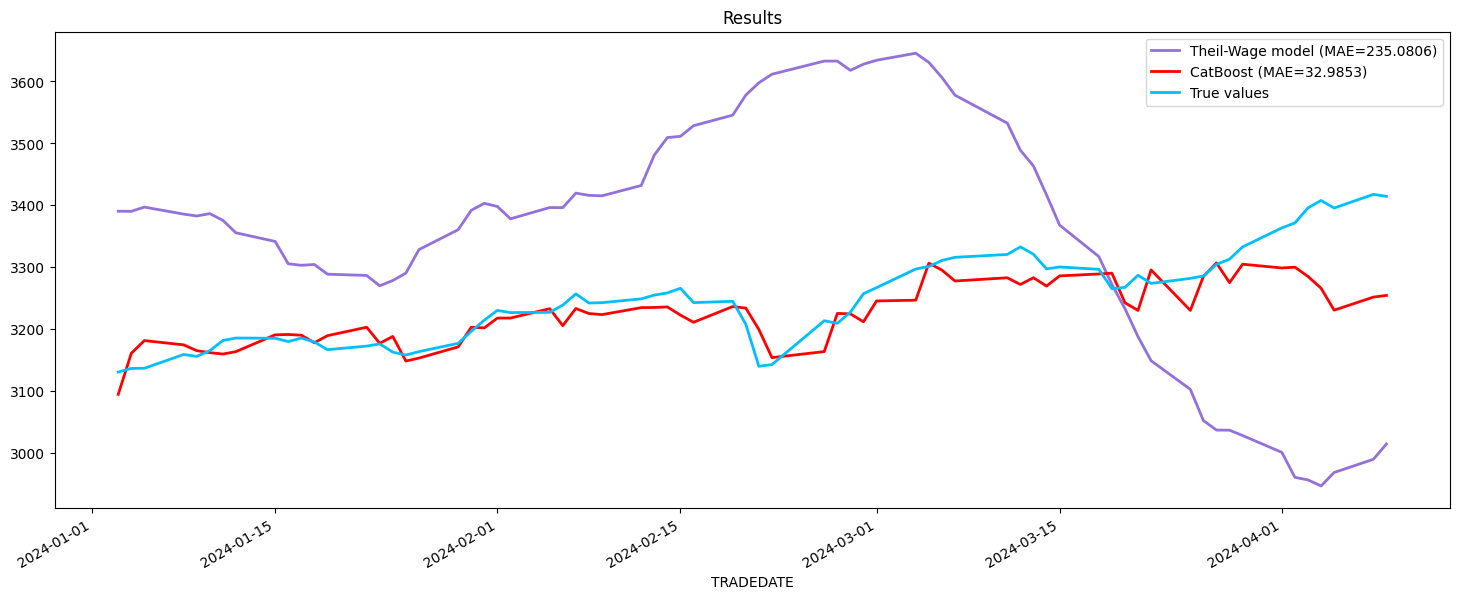

In [ ]:
mpl.rcParams['lines.linewidth'] = 2
plt.figure(figsize=(18, 7))
plt.title("Results")
stats_preds.plot(c='mediumpurple', label='Theil-Wage model (MAE={})'.format(np.round(MAE(true_close, stats_preds), 4)))
model_preds.plot(c='red', label='CatBoost (MAE={})'.format(np.round(MAE(true_close, model_preds), 4)))
true_close.plot(c='deepskyblue', label='True values')
plt.legend()
plt.show()